# Bag of Words Meets Bags of Popcorn 

IDMB 영화 리뷰를 로드하고 정제하여 간단한 BOW 모델을 적용하여 리뷰가 추천인지 아닌지에 예측하는 것의 정확도를 확인

[kaggle Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/overview)

[참고](https://github.com/corazzon/KaggleStruggle/blob/master/word2vec-nlp-tutorial/tutorial-part-1.ipynb)

# 라이브러리 로드

In [1]:
import pandas as pd

# 데이터 로드

In [2]:
 # header=0        파일 첫번째 줄에 열 이름 존재 
 # delimiter='\t'  필드가 탭으로 구분
 # quoting = 3     쌍따옴표 무시

# 학습데이터
train = pd.read_csv('data/labeledTrainData.tsv', 
                    header=0, delimiter='\t', quoting=3)
# 테스트 데이터
test = pd.read_csv('data/testData.tsv', 
                    header=0, delimiter='\t', quoting=3)

print(train.shape)
print(test.shape)

(25000, 3)
(25000, 2)


In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   review  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [7]:
train["sentiment"].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [8]:
train["review"][0][:1000] # html 태그를 정제해줄 필요가 있어보임

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

# 텍스트 전처리

In [9]:
# !pip install BeautifulSoup4

In [10]:
!pip show BeautifulSoup4

Name: beautifulsoup4
Version: 4.9.1
Summary: Screen-scraping library
Home-page: http://www.crummy.com/software/BeautifulSoup/bs4/
Author: Leonard Richardson
Author-email: leonardr@segfault.org
License: MIT
Location: e:\anaconda\lib\site-packages
Requires: soupsieve
Required-by: conda-build


## BeautifulSoup을 통해 html태그 제거

In [11]:
from bs4 import BeautifulSoup

# html 태그 제거 전
print(train["review"][0][:1000])

# html 태그 제거
example1 = BeautifulSoup(train['review'][0], "html5lib")
example1.get_text()[:1000]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 2

## 정규표현식을 통해 특수문자 제거

In [12]:
import re

# 소문자와 대문자가 아닌 것은 공백으로 대체
letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

## 모두 소문자로 변환

In [13]:
lower_case = letters_only.lower()
lower_case[:700]

' with all this stuff going down at the moment with mj i ve started listening to his music  watching the odd documentary here and there  watched the wiz and watched moonwalker again  maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  some of it has subtle messages about mj s feeling towards the press and also the obvious message of drugs are bad m kay visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyw'

## 토큰화

In [14]:
words = lower_case.split()

print(len(words))
words[:7]

437


['with', 'all', 'this', 'stuff', 'going', 'down', 'at']

## 불용어 제거

In [15]:
# NLTK data 설치
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
import nltk
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [17]:
# stopwords 를 제거한 토큰
words = [w for w in words if not w in stopwords.words('english')]

print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

## Stemming

In [18]:
# 처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [19]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]

# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

## Lemmatization

In [20]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

words = [wordnet_lemmatizer.lemmatize(w) for w in words]

# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

# 텍스트 전처리 함수화

In [21]:
def text_preprocessing(raw_text):
    # HTML 제거
    del_tag = BeautifulSoup(raw_text, 'html.parser').get_text()
    
    # 영문자가 아닌 문자는 공백으로 전환
    letters_only = re.sub('[^a-zA-Z]', ' ', del_tag)
    
    # 소문자 변환 및 토큰화
    words = letters_only.lower().split()
    
    # Stopwords를 리스트에서 세트 형태로 변환하여 저장
    stops = set(stopwords.words('english'))
    
    # Stopwords 제거
    meaningful_words = [w for w in words if not w in stops]
    
    # Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    
    # 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(stemming_words) ) # join()은 리스트를 특정 구분자로 포함해 문자열로 변환해주는 함수

In [22]:
# 함수 테스트
clean_text = text_preprocessing(train['review'][0])
clean_text

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [24]:
# 학습 데이터 전체 전처리
num_reviews = train['review'].size
num_reviews

clean_train_reviews = []

for i in range(0, num_reviews):
    if (i + 1)%5000 == 0:
         print('Review {} of {} '.format(i+1, num_reviews))
    clean_train_reviews.append(text_preprocessing(train['review'][i]))

Review 5000 of 25000 
Review 10000 of 25000 
Review 15000 of 25000 
Review 20000 of 25000 
Review 25000 of 25000 


In [27]:
# 테스트 데이터 전체 전처리
clean_test_reviews = []

for i in range(0, num_reviews):
    if(i+1) % 5000 == 0:
        print('Review {} of {}' .format(i+1, num_reviews))
    clean_test_reviews.append(text_preprocessing(test['review'][i]))

Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000
Review 25000 of 25000


In [28]:
# 멀티 프로세싱
# 참고 : https://gist.github.com/yong27/7869662
# http://www.racketracer.com/2016/07/06/pandas-in-parallel/

from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [29]:
# 멀티프로세싱 방식이 너무 오래걸려 진행하지않음
# %time clean_train_reviews = apply_by_multiprocessing(train['review'], review_to_words, workers=4)

In [30]:
# time clean_test_reviews = apply_by_multiprocessing(test['review'], review_to_words, workers=4)

# 워드 클라우드

In [33]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

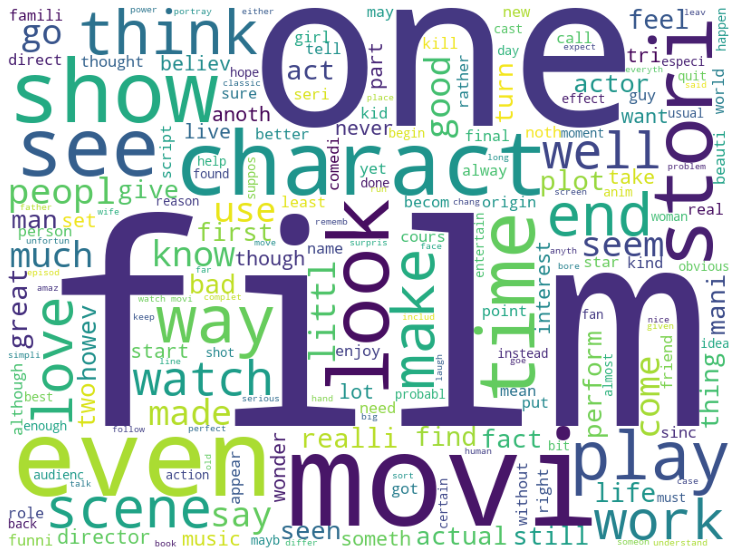

Wall time: 36.2 s


In [34]:
# 학습 데이터의 모든 단어에 대한 워드 클라우드
%time displayWordCloud(' '.join(clean_train_reviews))

## 단어 분석

In [36]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [49]:
x= clean_train_reviews[0]
x= str(x).split() # split()은 문자열을 특정 구분자로 나누어 리스트로 변환하는 함수

print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

In [57]:
# 단어 수 
count_words = lambda x : len(str(x).split()) # def count_words 같은 느낌
train['num_words'] = list(map(count_words, clean_train_reviews)) # map() : 각 요소들에 특정한 함수를 적용시킬 때 쓰는 함수

In [58]:
train.head()

,id,sentiment,review,num_words
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",219
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",84
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",240
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",189
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",210


In [61]:
# 중복 단어 수
count_unique_words = lambda x : len(set(str(x).split()))
train['unique_num_words'] = list(map(count_unique_words, clean_train_reviews))

In [62]:
train.head()

,id,sentiment,review,num_words,unique_num_words
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",219,156
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",84,63
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",240,201
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",189,158
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",210,188


## 시각화

In [69]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야합니다.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨집니다.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

# 그래프 스타일
plt.style.use("ggplot")

# 운영체제에 맞는 폰트 불러오기
font_family = get_font_family()

# 폰트 설정
plt.rc("font", family= font_family)

# 마이너스 폰트 설정
plt.rc("axes", unicode_minus=False)

# retina display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Text(0.5, 1.0, '리뷰별 고유한 단어 수 분포')

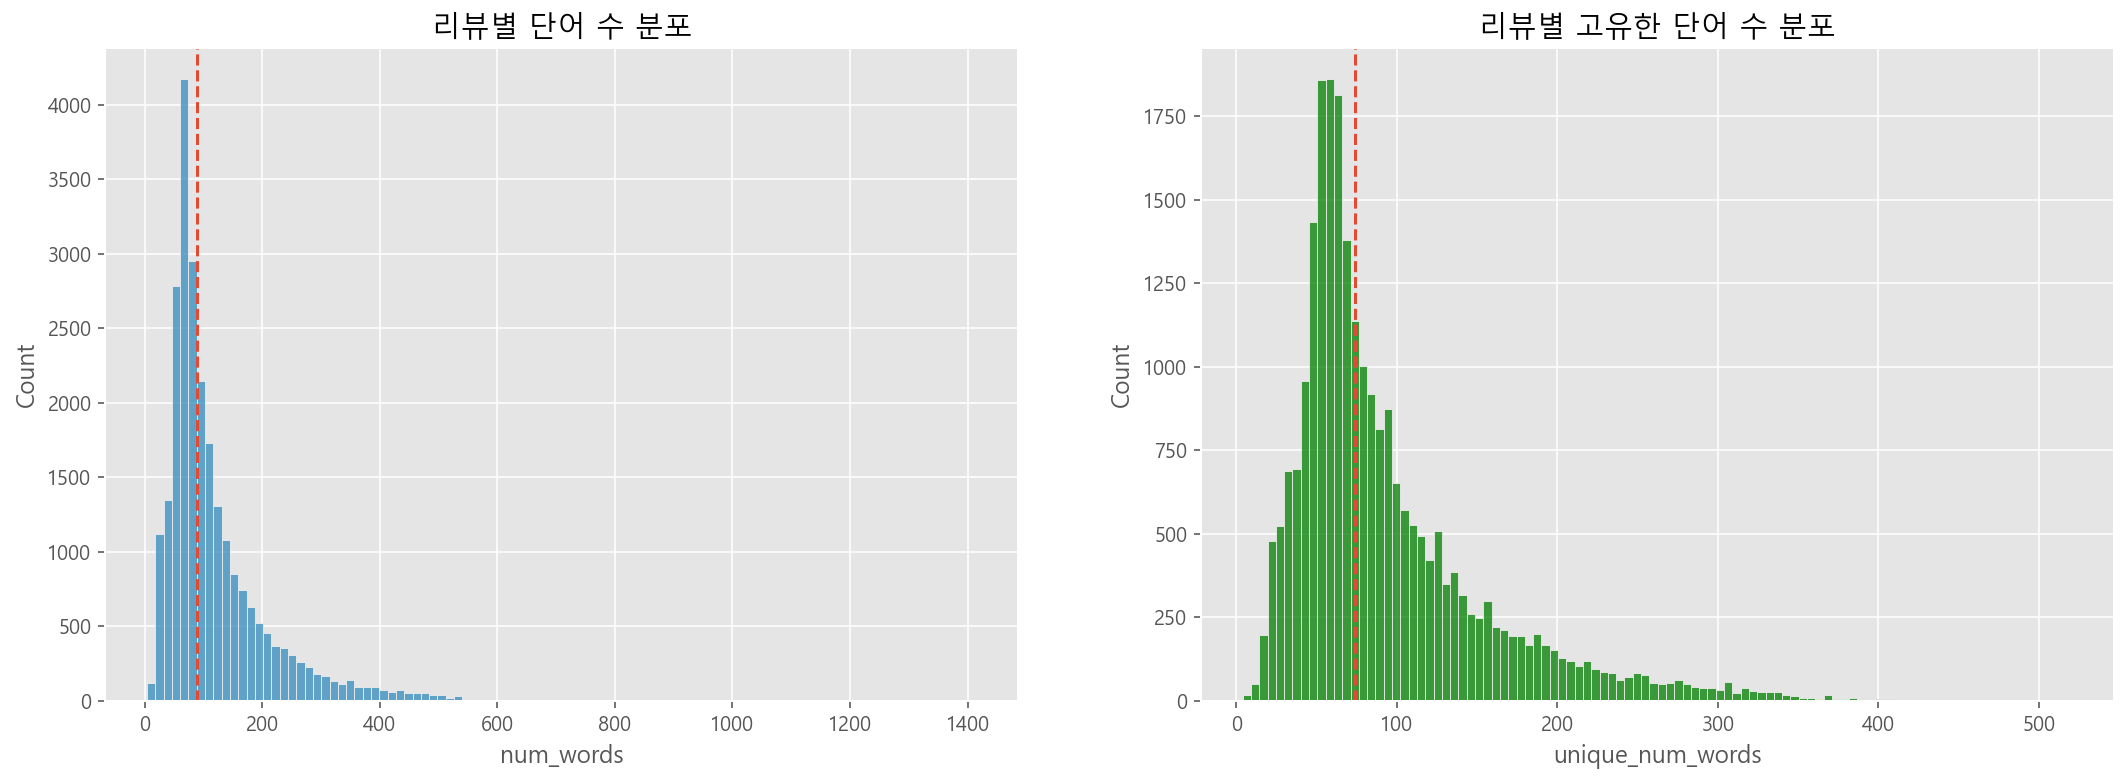

In [70]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18,6)

sns.histplot(train['num_words'], ax=axes[0], bins=100)
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('리뷰별 단어 수 분포')

sns.histplot(train['unique_num_words'], ax=axes[1], bins=100, color='g')
axes[1].axvline(train['unique_num_words'].median(), linestyle='dashed')
axes[1].set_title('리뷰별 고유한 단어 수 분포')

# CounterVectorizer _ 텍스트 데이터 벡터화

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3),
                             max_features = 20000)

In [73]:
vectorizer

CountVectorizer(max_features=20000, min_df=2, ngram_range=(1, 3))

In [74]:
# 여기에서는 하나의 과정만 묶어주어 pipeline이 불필요 할 수도 있다
# pipeline은 feature engineering의 여러 과정을 묶어 줄 때 사용
pipeline = Pipeline([
    ('vect', vectorizer),
])

 fit()이란 정규화 즉, 통계에서 정규분포를 만들게 하기 위해서 𝑥 값에서 평균을 빼고 그 값을 다시 표준편차로 나누어주는 작업을 하는데 이 작업을 하기 위해 **평균 𝜇과  표준편차 𝜎를 계산하는 작업이 fit()** 이고, **transform()은 정규화 작업을 해주는 것**

In [75]:
# 학습된 데이터로 피쳐 생성
%time train_data_features = pipeline.fit_transform(clean_train_reviews)
train_data_features

Wall time: 20.2 s


<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2762315 stored elements in Compressed Sparse Row format>

- 사이킷런에 구현된 벡터화 알고리즘이 fit을 사용해서 벡터화 하도록 되어 있다. 따라서 RF에서의 fit과 벡터화에 사용되는 fit은 다른 성격

- cross-validation 과 GridSearch 과정을 하나로 만들어 주는게 pipeline의 가장 큰 장점


이 코드에는 cross-validation 과 GridSearch 과정이 없는데 해당 과정은 모델의 성능(정확도)를 측정해 보는 과정이고, GridSearch는 최적의 하이퍼파라메터를 찾는 과정임

In [76]:
train_data_features.shape

(25000, 20000)

In [77]:
# 피쳐 이름 추출
vocab = vectorizer.get_feature_names()
vocab[:10]

['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [79]:
# 벡터화된 피쳐 확인
import numpy as np

dist= np.sum(train_data_features, axis=0)
pd.DataFrame(dist, columns=vocab)

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


In [82]:
# 각각의 행이 담고 있는 단어 확인
pd.DataFrame(train_data_features.toarray(), columns=vocab).head(10)

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 랜덤포레스트

In [84]:
!pip install scikit-learn

In [87]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=216)
forest

RandomForestClassifier(n_jobs=-1, random_state=216)

In [88]:
forest = forest.fit(train_data_features, train['sentiment'])

In [89]:
from sklearn.model_selection import cross_val_score
score = np.mean(cross_val_score(\
    forest, train_data_features, \
    train['sentiment'], cv=10, scoring='roc_auc'))
score

0.9277986559999999

# 테스트 데이터 예측

In [91]:
# 테스트 데이터 피쳐 생성
test_data_features = pipeline.transform(clean_test_reviews)

In [92]:
result = forest.predict(test_data_features)
result[:10]

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1], dtype=int64)

# Kaggle 제출용 예측 데이터 저장

In [93]:
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",1
3,"""7186_2""",1
4,"""12128_7""",1


In [94]:
output.to_csv('data/tutorial_1_BOW_{0:.5f}.csv'.format(score), index=False, quoting=3)

In [97]:
output_sentiment = output['sentiment'].value_counts()
output_sentiment 

0    12546
1    12454
Name: sentiment, dtype: int64

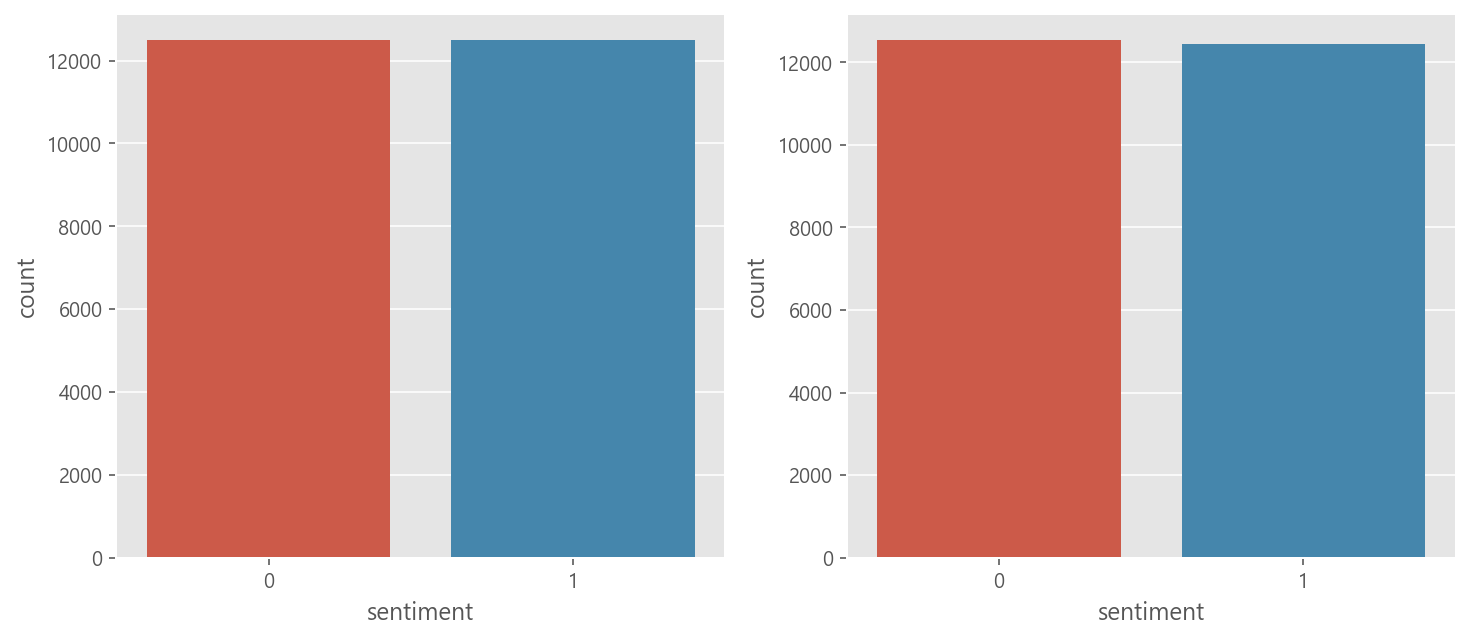

In [99]:
# 시각화
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(x=train['sentiment'], ax=axes[0])
sns.countplot(x=output['sentiment'], ax=axes[1])

kaggle 제출 결과 0.85512